# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [1]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [2]:
# Install keras
!pip install -U keras

You should consider upgrading via the 'c:\users\archi\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [5]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [6]:
# What do these sequences look like?
X_train_seq[0]

[863,
 103,
 376,
 802,
 38,
 57,
 4,
 101,
 2003,
 2573,
 322,
 138,
 4,
 522,
 637,
 26,
 1009,
 4,
 233,
 164,
 3808,
 3809,
 939,
 233,
 3,
 3810,
 3811,
 3812,
 3813,
 3814]

In [7]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [8]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  863,  103,
        376,  802,   38,   57,    4,  101, 2003, 2573,  322,  138,    4,
        522,  637,   26, 1009,    4,  233,  164, 3808, 3809,  939,  233,
          3, 3810, 3811, 3812, 3813, 3814])

### Build Model

In [9]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [10]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          251040    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 260,449
Trainable params: 260,449
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [12]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 6s 32ms/step - loss: 0.4061 - accuracy: 0.8732 - precision_m: 0.2277 - recall_m: 0.1802 - val_loss: 0.0859 - val_accuracy: 0.9803 - val_precision_m: 0.9032 - val_recall_m: 0.9099
Epoch 2/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0430 - accuracy: 0.9861 - precision_m: 0.9618 - recall_m: 0.9373 - val_loss: 0.0416 - val_accuracy: 0.9892 - val_precision_m: 0.9524 - val_recall_m: 0.9075
Epoch 3/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0114 - accuracy: 0.9981 - precision_m: 0.9918 - recall_m: 0.9864 - val_loss: 0.0580 - val_accuracy: 0.9874 - val_precision_m: 0.9714 - val_recall_m: 0.8832
Epoch 4/10
140/140 [==============================] - 4s 29ms/step - loss: 0.0043 - accuracy: 0.9991 - precision_m: 0.9964 - recall_m: 0.9921 - val_loss: 0.0767 - val_accuracy: 0.9839 - val_precision_m: 0.9714 - val_recall_m: 0.8482
Epoch 5/10
140/140 [==============================] - 4s 26ms/step -

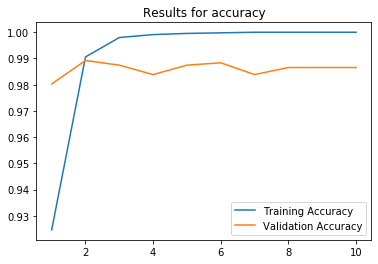

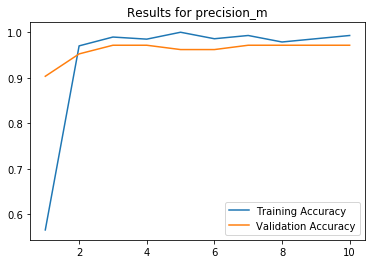

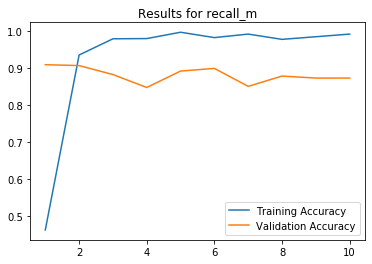

In [14]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()